---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). 

### Method Overview

We will begin modeling with sklearn's logistic regression. Logistic regression is often a good place to begin, since it often performs well on data sets of this size and because it is remarkably fast to train and predict. We will see, below, that our data set is highly imbalanced, and we will illustrate common methods to overcome predictions on unbalanced datasets.

We will then explore more computationally expensive methods to try to improve our results. Explanations of methods and motivations will be given along the way.

In [182]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,LeaveOneOut,train_test_split
import mglearn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report,roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
%matplotlib inline

# Data Set

In [2]:
df=pd.read_csv("train.csv",encoding = 'ISO-8859-1')

C:\Users\Mike\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Choose features that may be useful to helpful for prediction
traincolumns=["fine_amount","admin_fee","state_fee","late_fee","discount_amount","clean_up_cost",
              "judgment_amount","compliance"]
df=df[traincolumns]

In [4]:
#Check for NaN values
for col in traincolumns:
    print(df[col].isnull().sum())

1
0
0
0
0
0
0
90426


In [5]:
#Unfortunately, we will have to drop 90426 out of 250306 rows, since it doesn't contain values for the target.
#dropping the one row that has one Nan in the second column is inconsequential
df=df.dropna()

In [6]:
#Let us be sure that we, now, only have ones and zeros
df.compliance.unique()

array([ 0.,  1.])

In [7]:
#View the data set
df.head()

,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance
0,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0
1,750.0,20.0,10.0,75.0,0.0,0.0,855.0,1.0
5,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0
6,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0
7,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0


In [8]:
#Check the balance of the data set
len(df[df["compliance"]==0])/len(df)

0.927464348261196

We see that we have a highly imbalanced data set

In [9]:
#Train test split
X=df[traincolumns[:-1]]
y=df.compliance
X_train_val,X_test,y_train_val,y_test=train_test_split(X,y)
X_train,X_valid,y_train,y_valid=train_test_split(X_train_val,y_train_val)

# Logistic Regression

In [87]:
model1=LogisticRegression(random_state=2).fit(X_train,y_train)

In [88]:
print("Train Accuracy: {}\nValidation Accuracy: {}".format(model1.score(X_train,y_train),
                                                          model1.score(X_valid,y_valid)))

Train Accuracy: 0.9340835297780545
Validation Accuracy: 0.9336847021148843


The train and test score are nearly identical to the balance. Thus, I suspect the high imbalance has lead to a model that predicts the majority class. We must take measures to counteract this. But first, let's examine the confusion matrix, precision, recall, and auc_roc_score

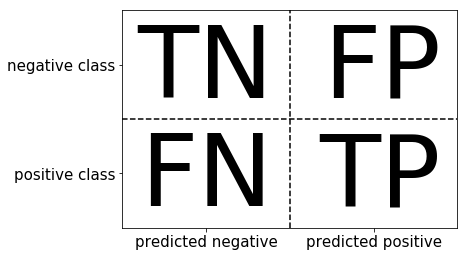

In [89]:
#plot the confusion matrix structure
mglearn.plots.plot_binary_confusion_matrix()

In [90]:
#Our confusion matrix
y1_pred_valid=model1.predict(X_valid)
confusion_matrix(y_valid,y1_pred_valid)

array([[27761,    35],
       [ 1953,   229]], dtype=int64)

sklearn sorts classes in ascending order. Thus, the 0 class (majority class) is the negative class (top row), and the 1 class is the positive class.

In [91]:
print(classification_report(y_valid,y1_pred_valid))

             precision    recall  f1-score   support

        0.0       0.93      1.00      0.97     27796
        1.0       0.87      0.10      0.19      2182

avg / total       0.93      0.93      0.91     29978



In [92]:
y_valid_dec=model1.decision_function(X_valid)

In [93]:
print("AUC: {}".format(roc_auc_score(y_valid,y_valid_dec)))

AUC: 0.7535533124733969


We see that our model is nearly a majority class classifier. It does not predict the positive class very well. We could improve the prediction of the minority (positive) class if we lower the threshold below zero. In otherwords, instead of predicting class 1 for decision values above zero, it will predict class 1 if the decision value is higher than some lower (negative number) value.

Let's see if adjusting the threshold value will help us efficiently capture the 1 target (positive class) values. We will look at the ROC curve. We know that lowering the threshold will allow us to capture more true positives, but the false positives will increase as well. Viewing the ROC curve (true positives vs. false positives) will allow us to see how where we begin getting deminishing returns.

First, let us find the min values for the decision function, so we know what range we should consider.

In [94]:
pd.Series(y_valid_dec).describe()

count    29978.000000
mean        -3.048071
std          2.335026
min        -30.081691
25%         -2.908841
50%         -2.908841
75%         -2.490797
max        106.853572
dtype: float64

To generate the values of the roc curve, we could use sklearn.metrics method roc_curve, however, I will manually define our own roc curve generating function. This, way we can manually set the number of data points plotted, and we can visually inspect the inner workings of this plot. This will be helpful if we decide to alter our model to make predictions at a lower threshold, and also help us to generate "loss" functions based on confusion matrix values, that derive from predictions at different thresholds. For example, suppose we knew the cost of false positives and false negatives, and knew the revenue gained for true positives (or true negatives). We could find then derive a profit function, which would be a function of threshold. Presumably we would want to maximize this function.

In [95]:
def roc_curve_manual(y_true,y_pred_dec,low_thresh,high_thresh,increment):
    true_pos_rate=[]
    false_pos_rate=[]
    true_neg_rate=[]
    false_neg_rate=[]
    for thresh in np.arange(low_thresh,high_thresh,increment):
        y_pred_lt=(y_pred_dec>thresh)*1
        ltc=confusion_matrix(y_true,y_pred_lt)
        tn=ltc[0][0]
        fn=ltc[1][0]
        fp=ltc[0][1]
        tp=ltc[1][1]
        tpr=tp/(tp+fn)
        fpr=fp/(fp+tn)
        tnr=tn/(tn+fp)
        fnr=fn/(tp+fn)
        true_pos_rate.append(tpr)
        false_pos_rate.append(fpr)
        true_neg_rate.append(tnr)
        false_neg_rate.append(fnr)
    return false_pos_rate,true_pos_rate,false_neg_rate,true_neg_rate

In [212]:
fpr,tpr,fnr,tnr=roc_curve_manual(y_valid,y_valid_dec,-30,10,0.1)

Text(0.5,1,'ROC Curve')

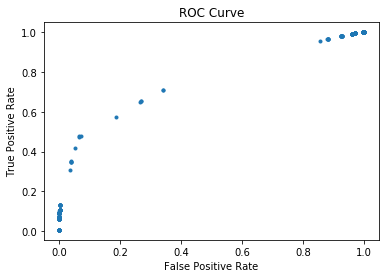

In [213]:
plt.plot(fpr,tpr,".")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

Let's isolate the threshold that leads to the the point around .5 tpr.

In [215]:
tpr_series=pd.Series(tpr)
tpr_series[(tpr_series>.45)&(tpr_series<.55)]

277    0.478460
278    0.476169
279    0.472502
dtype: float64

In [217]:
#Determine the optimum threshold
opt_thresh=np.arange(-30,10,0.1)[277]
opt_thresh

-2.2999999999996064

In [220]:
#Define the predictor with the above threshold
def opt_pred(X):
    y_dec=model1.decision_function(X)
    return (y_dec>-2.3)*1

In [221]:
yopt_valid_pred=opt_pred(X_valid)

In [222]:
print(classification_report(y_valid,yopt_valid_pred))

             precision    recall  f1-score   support

        0.0       0.96      0.93      0.94     27796
        1.0       0.34      0.48      0.40      2182

avg / total       0.91      0.90      0.90     29978



We have found a way to improve the recall of the positive class. Now, let's investigate if we can develop a better model that is adapted to an imbalanced data set.

## Hypothetical Optimization Problem

Let's consider a hypothetical case where we aim to maximize our profits. We wish to correctly identify the positive class. We know the income recieved for identification of each true positive and the cost for each false positive. Let's suppose true positives bring in 10 dollars each and false positives cost us 1 dollar each. 

We wish to maximize our profit, which is the difference of ten times the true positives, and the number of false positives. Can we find the threshold that maximizes our profits?

In [244]:
#Define a profit function that returns profits over the range of decision values
def profit_curve(y_true,y_pred_dec,low_thresh,high_thresh,increment):
    profits=[]
    thresh_list=list(np.arange(low_thresh,high_thresh,increment))
    for thresh in thresh_list:
        y_pred_lt=(y_pred_dec>thresh)*1
        ltc=confusion_matrix(y_true,y_pred_lt)
        fp=ltc[0][1]
        tp=ltc[1][1]
        profit=10*tp-fp
        profits.append(profit)
    return profits,thresh_list

In [245]:
profits,thresholds=profit_curve(y_valid,y_valid_dec,-30,10,0.1)

Text(0.5,1,'Profits vs. Threshold')

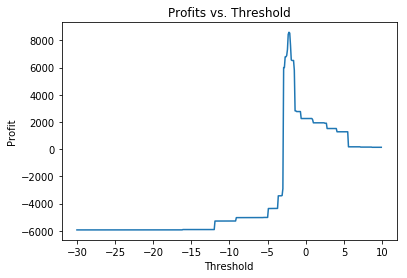

In [246]:
plt.plot(thresholds,profits,"-")
plt.xlabel("Threshold")
plt.ylabel("Profit")
plt.title("Profits vs. Threshold")

In [252]:
max_profit=max(profits)
optimum_threshold=thresholds[profits.index(max_profit)]
print("Maximum Profit: {}\nOptimum Threshold: {}".format(max_profit,optimum_threshold))

Maximum Profit: 8605
Optimum Threshold: -2.199999999999605


Not surprisingly, we found the optimum threshold for maximum profit to be very near the optimum threshold found from the tpr vs. fpr graph.

Furthermore, the maximized profit looks to be at least four times larger than the profit expected from the model without adjusting the threshold (i.e. the profit we would expect at threshold=0).

## Dealing with Unbalanced Data Sets

Let us consider a few techniques to deal with this highly unbalanced data set. We aim to improve our auc score primarily, and our accuracy secondarily.

### class_weight parameter

The logistic regression classifier has a class_weight parameter. Setting this parameter to "balanced" imposes a penalty on making mistakes in the minority class. The penalty is inversely proportional to the class's frequency in the input data.

In [98]:
model2=LogisticRegression(random_state=2,class_weight="balanced").fit(X_train,y_train)

In [99]:
y2_valid_dec=model2.decision_function(X_valid)

In [100]:
print("Train Accuracy: {}".format(model2.score(X_train,y_train)))
print("Validation Accuracy: {}".format(model2.score(X_valid,y_valid)))
print("AUC: {}".format(roc_auc_score(y_valid,y2_valid_dec)))

Train Accuracy: 0.8999688653649424
Validation Accuracy: 0.9025285209153379
AUC: 0.7534628768404187


In [101]:
pd.Series(y2_valid_dec).describe()

count    29978.000000
mean        -0.265379
std          2.258371
min         -7.914724
25%         -0.443832
50%         -0.443832
75%         -0.328895
max        183.253307
dtype: float64

In [102]:
fpr2,tpr2,fnr2,tnr2=roc_curve_manual(y_valid,y2_valid_dec,-7.9,10,0.1)

Text(0.5,1,'ROC Curve')

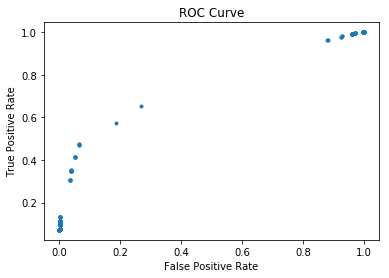

In [103]:
plt.plot(fpr2,tpr2,".")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

This did not seem to help at all. Let's repeat these two steps with a support vector machine.

### Support Vector Machine

In order to get the auc roc score and curve, we need to set the probability parameter to True in the SVC. This will increase the time to fit the model, significantly. However, this is a necessary evil.

In [105]:
svm1=SVC(probability=True).fit(X_train,y_train)

In [106]:
y3_valid_dec=svm1.decision_function(X_valid)

In [107]:
print("Train Accuracy: {}".format(svm1.score(X_train,y_train)))
print("Validation Accuracy: {}".format(svm1.score(X_valid,y_valid)))
print("AUC: {}".format(roc_auc_score(y_valid,y3_valid_dec)))

Train Accuracy: 0.9357848151937019
Validation Accuracy: 0.9351190873307091
AUC: 0.5121161407209447


This result is surprisingly worse. Let's investigate what went wrong with a confusion matrix.

In [108]:
y3_pred_valid=svm1.predict(X_valid)

In [109]:
confusion_matrix(y_valid,y3_pred_valid)

array([[27784,    12],
       [ 1933,   249]], dtype=int64)

In [114]:
fpr4,tpr4,thresholds4=roc_curve(y_valid,y3_valid_dec)

Text(0.5,1,'ROC Curve')

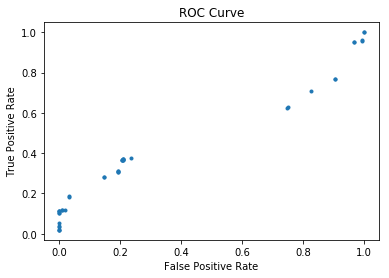

In [115]:
plt.plot(fpr4,tpr4,".")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

This is not an ideal ROC curve. Let's train another svm with the class_weight parameter set to "balanced".

In [118]:
svm2=SVC(probability=True,class_weight="balanced").fit(X_train,y_train)

In [119]:
y4_valid_dec=svm2.decision_function(X_valid)

In [120]:
print("Train Accuracy: {}".format(svm2.score(X_train,y_train)))
print("Validation Accuracy: {}".format(svm2.score(X_valid,y_valid)))
print("AUC: {}".format(roc_auc_score(y_valid,y4_valid_dec)))

Train Accuracy: 0.8998799092647778
Validation Accuracy: 0.9023617319367536
AUC: 0.6872861943353425


We see an improvement over the svm not using the balanced class weight, however, the auc roc score is still lower than that obtained with logistic regression. Let's abandon the svm approach and move on to other methods.

### Up Sampling the Minority Class

Since the support vector machine did not help us achieve a higher auc roc score (and added a lot more time spent on training and classifying), we will go back to the logistic regression. However, we will attempt to "manufacture" a balanced data set. This technique will help the machine learning algorithm train a model that values predictions of the positive (minority) class as much as predictions of the majority class.

The idea is to duplicate random occurences of the minority class, untill the classes are in equal proportion. This is a three step process. 

Step1: Separate rows of the data frame into separate data frames based on their class.

Step2: Resample the minority class, with replacement, so that the minority class has the same number of observations (rows) as the majority class.

step3: Combine the resampled minority class with the majority class and call this dataframe our train set.

In [122]:
#sklearn has a method to help us with resampling
from sklearn.utils import resample

In [128]:
#Combine the X_train with the target set y_train
df_train=pd.concat([X_train,y_train],axis=1)

# Separate majority and minority classes into separate dataframes
df_majority=df_train[df_train.compliance==0]
df_minority=df_train[df_train.compliance==1]

#Use sklearn's resample method to resample the minority class. The first input is the dataframe to resample, then
#we set replace=True. The n_samples parameter sets the number of samples to generate, i.e. the total number of rows
#Thus, we want to set this parameter to len(df_majority). Finally, we can set the random_state.
df_minority_upsampled = resample(df_minority,replace=True,n_samples=len(df_majority),random_state=2)

#Combine the df_minority_upsampled dataframe with the df_majority using concat
df_upsampled=pd.concat([df_majority,df_minority_upsampled])

In [129]:
#Let's check the counts of the majority and minority classes in our new dataframe, df_upsampled
print("Majority class rows: {}\nMinority class rows {}".format(len(df_upsampled[df_upsampled.compliance==0]),
                                                           len(df_upsampled[df_upsampled.compliance==1])))

Majority class rows: 83424
Minority class rows 83424


In [130]:
#Create a new X_train and target set from our balanced set
X_train_balanced=df_upsampled[traincolumns[:-1]]
y_train_balanced=df_upsampled.compliance

In [131]:
#Train a new logistic regression model
logreg3=LogisticRegression(random_state=2).fit(X_train_balanced,y_train_balanced)

In [132]:
#Find the decision_function values of the validation set
y5_valid_dec=logreg3.decision_function(X_valid)

In [133]:
#Print the train score (balanced set), validation score of our original validation set, and auc roc score
print("Train Accuracy: {}".format(logreg3.score(X_train_balanced,y_train_balanced)))
print("Validation Accuracy: {}".format(logreg3.score(X_valid,y_valid)))
print("AUC: {}".format(roc_auc_score(y_valid,y5_valid_dec)))

Train Accuracy: 0.7033167913310319
Validation Accuracy: 0.9025285209153379
AUC: 0.7534615907913079


We're seeing almost the same accuracy. Let's try manipulating the C parameter of the logistic regression model to try to get a more complex model. C is inversely proportional to the penalty strength, so let's make C large to make the penalty small.

In [134]:
logreg4=LogisticRegression(C=1e40,random_state=2).fit(X_train_balanced,y_train_balanced)

In [135]:
#Find the decision_function values of the validation set
y6_valid_dec=logreg4.decision_function(X_valid)

In [136]:
#Print the train score (balanced set), validation score of our original validation set, and auc roc score
print("Train Accuracy: {}".format(logreg4.score(X_train_balanced,y_train_balanced)))
print("Validation Accuracy: {}".format(logreg4.score(X_valid,y_valid)))
print("AUC: {}".format(roc_auc_score(y_valid,y6_valid_dec)))

Train Accuracy: 0.7033167913310319
Validation Accuracy: 0.9025285209153379
AUC: 0.7534615907913079


Upsampling the minority class did not help.

### Down Sampling Majority Class.

Down sampling the majority class has a similar effect of upsampling the minority class. The method is also similar, except we resample the majority class with replacement=False and the n_samples set to len(df_minority)

In [138]:
#Downsample the majority class
df_majority_downsampled = resample(df_majority,replace=False,n_samples=len(df_minority),random_state=2)

#Combine the df_majority_downsampled dataframe with the df_minority using concat
df_downsampled=pd.concat([df_minority,df_majority_downsampled])

In [139]:
#Let's check the counts of the majority and minority classes in our new dataframe, df_downsampled
print("Majority class rows: {}\nMinority class rows {}".format(len(df_downsampled[df_downsampled.compliance==0]),
                                                           len(df_downsampled[df_downsampled.compliance==1])))

Majority class rows: 6508
Minority class rows 6508


In [140]:
#Create a new X_train and target set from our downsampled balanced set
X_train_balanced_down=df_downsampled[traincolumns[:-1]]
y_train_balanced_down=df_downsampled.compliance

In [141]:
#Fit a new logistic regression model
logreg5=LogisticRegression(C=1e40,random_state=2).fit(X_train_balanced_down,y_train_balanced_down)

In [142]:
#Find the decision_function values of the validation set
y7_valid_dec=logreg5.decision_function(X_valid)

In [143]:
#Print the train score (balanced set), validation score of our original validation set, and auc roc score
print("Train Accuracy: {}".format(logreg5.score(X_train_balanced_down,y_train_balanced_down)))
print("Validation Accuracy: {}".format(logreg5.score(X_valid,y_valid)))
print("AUC: {}".format(roc_auc_score(y_valid,y7_valid_dec)))

Train Accuracy: 0.701060233558697
Validation Accuracy: 0.9025285209153379
AUC: 0.7529941119395611


## Decision Tree Ensembles

Our attempts to find an appropriate model using linear methods failed to achieve the results we wanted, i.e. a high auc roc score. Let us now consider two decision tree ensembles, random forests and boosted stumps. Decision trees have the disadvantage of slow learning and predicting, but since our data set is relatively small, this shouldn't be a problem. In fact, small data sets require extracting as much information out the data as possible, and this is where decision trees excel. The advantage of trees is that they can increase model complexity significantly. The disadvantage is that it is easy to overfit your models (too complex). However, random forests and boosted stumps can mitigate this effect.

A single tree makes it easy to follow the decision making process, however, we are not so much concerned with the process of the tree, as with its final performance. For this reason, let's skip the single tree and move on to the tree ensembles, which have a proven track record.

### Random Forests

In [152]:
#Fit a random forest classifier with n_estimators=1000
rf1=RandomForestClassifier(n_estimators=1000,random_state=2).fit(X_train,y_train)

In [169]:
#Get the predict probabilities
y1_valid_proba=rf1.predict_proba(X_valid)[:,1]

In [170]:
print("Train Accuracy: {}\nValidation Accuracy: {}\nAUC: {}".format(rf1.score(X_train,y_train),
                                                                    rf1.score(X_valid,y_valid),
                                                                   roc_auc_score(y_valid,y1_valid_proba)))

Train Accuracy: 0.9357848151937019
Validation Accuracy: 0.9351190873307091
AUC: 0.75792022413132


In [171]:
y_rf_pred_valid=rf1.predict(X_valid)
print(classification_report(y_valid,y_rf_pred_valid))

             precision    recall  f1-score   support

        0.0       0.93      1.00      0.97     27796
        1.0       0.95      0.11      0.20      2182

avg / total       0.94      0.94      0.91     29978



Although the auc hasn't improved much, we see that the precision of the positive class (class 1) has improved from .87 to .95 since the first time we measured, while recall has remained the same. This may be a slight improvement. However, it could also be due to chance.

Let's train another random forest classifier with the class_weight parameter set to "balanced."

In [157]:
#Train another random forest classifier with class_weight="balanced"
rf2=RandomForestClassifier(n_estimators=1000,class_weight="balanced",random_state=2).fit(X_train,y_train)

In [177]:
#Get the predict and predict probabilities of X_valid
y2_valid_proba=rf2.predict_proba(X_valid)[:,1]
y2_rf_pred_valid=rf2.predict(X_valid)

In [178]:
print("Train Accuracy: {}\nValidation Accuracy: {}\nAUC: {}".format(rf2.score(X_train,y_train),
                                                                    rf2.score(X_valid,y_valid),
                                                                   roc_auc_score(y_valid,y2_valid_proba)))

Train Accuracy: 0.8998799092647778
Validation Accuracy: 0.9023950897324705
AUC: 0.7578625167994287


In [179]:
#Classification report
print(classification_report(y_valid,y2_rf_pred_valid))

             precision    recall  f1-score   support

        0.0       0.96      0.94      0.95     27796
        1.0       0.37      0.48      0.42      2182

avg / total       0.92      0.90      0.91     29978



We finally see some improvement! At the expense of total accuracy and precision of the positive class, we see a large improvement of the recall of the positive class (from 0.11 to 0.48)

### Gradient Boosted Stumps

In [186]:
#train a gradient boosted ensemble of tree stumps with 5000 estimators, and the default max depth of 3
gbt1=GradientBoostingClassifier(random_state=2,n_estimators=5000).fit(X_train,y_train)

In [187]:
#Get the predict and predict probabilities of X_valid
y3_valid_proba=gbt1.predict_proba(X_valid)[:,1]
y3_gbt_pred_valid=gbt1.predict(X_valid)

In [188]:
print("Train Accuracy: {}\nValidation Accuracy: {}\nAUC: {}".format(gbt1.score(X_train,y_train),
                                                                    gbt1.score(X_valid,y_valid),
                                                                   roc_auc_score(y_valid,y3_valid_proba)))

Train Accuracy: 0.9357848151937019
Validation Accuracy: 0.9351190873307091
AUC: 0.757939251063035


In [190]:
#Classification report
print(classification_report(y_valid,y3_gbt_pred_valid))

             precision    recall  f1-score   support

        0.0       0.93      1.00      0.97     27796
        1.0       0.95      0.11      0.20      2182

avg / total       0.94      0.94      0.91     29978



Let's try 1000 estimators and max_depth=6

In [191]:
gbt2=GradientBoostingClassifier(random_state=2,n_estimators=1000,max_depth=6).fit(X_train,y_train)

In [192]:
#Get the predict and predict probabilities of X_valid
y4_valid_proba=gbt2.predict_proba(X_valid)[:,1]
y4_gbt_pred_valid=gbt2.predict(X_valid)

In [194]:
print("Train Accuracy: {}\nValidation Accuracy: {}\nAUC: {}".format(gbt2.score(X_train,y_train),
                                                                    gbt2.score(X_valid,y_valid),
                                                                   roc_auc_score(y_valid,y4_valid_proba)))

Train Accuracy: 0.9357848151937019
Validation Accuracy: 0.9351190873307091
AUC: 0.7579396137948354


In [195]:
#Classification report
print(classification_report(y_valid,y4_gbt_pred_valid))

             precision    recall  f1-score   support

        0.0       0.93      1.00      0.97     27796
        1.0       0.95      0.11      0.20      2182

avg / total       0.94      0.94      0.91     29978



No improvement by making the depth deeper. Let's try assigning a higher weight to the positive class in the fit method.

In [203]:
#Create a series of weights, where class one will be given weight 13 and class 0 will have weight 1
weight_series=y_train.apply(lambda x: 13 if x==1 else 1)

In [208]:
gbt3=GradientBoostingClassifier(random_state=2,n_estimators=1000).fit(X_train,y_train,sample_weight=weight_series)

In [209]:
#Get the predict and predict probabilities of X_valid
y5_valid_proba=gbt3.predict_proba(X_valid)[:,1]
y5_gbt_pred_valid=gbt3.predict(X_valid)

In [210]:
print("Train Accuracy: {}\nValidation Accuracy: {}\nAUC: {}".format(gbt3.score(X_train,y_train),
                                                                    gbt3.score(X_valid,y_valid),
                                                                   roc_auc_score(y_valid,y5_valid_proba)))

Train Accuracy: 0.8998799092647778
Validation Accuracy: 0.9023950897324705
AUC: 0.7579397786729266


In [211]:
#Classification report
print(classification_report(y_valid,y5_gbt_pred_valid))

             precision    recall  f1-score   support

        0.0       0.96      0.94      0.95     27796
        1.0       0.37      0.48      0.42      2182

avg / total       0.92      0.90      0.91     29978



We see that we have recovered the same results as the class_weight balanced random forest

## Results

The balanced forest and the balanced boosted stumps had the same results. We see that the balanced boosted stumps has a slightly better precision score for the positive class than the threshold optimized logistic regression model, and all other values are similar. Let's choose model gbt3 as our choice model. The validation scores are only slightly better in this model than the threshold optimized linear model, so if speed of prediction was paramount, we could have chosen the linear model.

Let's test this model on the test set.

In [228]:
y6_test_proba=gbt3.predict_proba(X_test)[:,1]
y6_gbt_pred_test=gbt3.predict(X_test)

In [227]:
print("Test Accuracy: {}\nAUC: {}".format(gbt3.score(X_test,y_test),roc_auc_score(y_test,y6_test_proba)))

Test Accuracy: 0.9020015011258444
AUC: 0.7614329939851483


In [229]:
#Classification report
print(classification_report(y_test,y6_gbt_pred_test))

             precision    recall  f1-score   support

        0.0       0.96      0.93      0.95     37063
        1.0       0.37      0.49      0.42      2907

avg / total       0.92      0.90      0.91     39970



## Conclusion

Our best predictor had a test accuracy of 90%, and AUC of 0.76. The test accuracy is 3% less than the accuracy of a dummy majority class predictor, however, we managed to achieve a recall of 49% and precision of 37% in the minority class, and an overall recall of 90% and precision of 92%.

We used several methods to deal with a highly unbalanced data set in attempt to improve the AUC score. All methods failed to improve AUC, however, we were able to increase the precision and recall values of the minority class to those mentioned previously.

Lastly, we demonstrated a hypothetical optimization problem that demonstrates the use of increasing the recall of the minority class, even if it is associated with a decreased accuracy.